<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modelling-RL/blob/main/bayesian_modelling_pomdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/
!pip install numpyro
!pip install funsor
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

/content
fatal: destination path 'Bayesian-Modelling-RL' already exists and is not an empty directory.
/content/Bayesian-Modelling-RL
Already up to date.
/content


In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import os
import time
import copy
import random
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

# Bayesian Modelling POMDPs Transition models

Our scientific problem is in the realm of planning and decision making,
\
Our assumptions our that we do not know how our model interacts with the environment (transition model with probabilities), and that an execution of a trajectory (the path of the agent through the state space up until the horizon) is costly.

Because of these assumptions, we will define a "fictive" environment - with our belief of what are the probabilities for the agent to succeed; and basically train our Agent using model-based Reinforcment Learning on that environment.

We are looking into learning the Transition Model parameters, using few observations, and improving the accuracy of our Agent through improving our belief of the transition model.

For this we will use Bayesian Modelling.

# Tic Tac Toe POMDP Domain

To show improvement in our Agent accuracy, we will define a Tic Tac Toe with probabilities domain.

We are training our AI Agent to play Tic Tac Toe with a probability to successfully mark 'O' in a given cell.

The (Real) parameters (that are unknown to us) for successfully marking 'O' in a given cell are:

\begin{align}
        \text{Transition_Proability}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.3 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

Where 'x' is the cell our AI Agent is trying to mark.

Our Agent is learning using Q-Learning Reinforcment Learning algorithm, given an estimate* for his Transition Probability model.

We want to improve our estimate each iteration, and by thus improve our accuracy (how many times our AI Agent wins).

A full iteration is defined by:
    
    1. Train our AI Agent and compute an optimal policy using Q-Learning, against an optimal Tic Tac Toe opponent,
    with our model of the env. which has an estimate for each transition (cell marking) probability.

    2. Evaluate our optimal policy from clause 1 through playing against a random Tic Tac Toe opponent (uniform probability to mark 'X' in each cell).
    In this step we do not collect observations, this is done for evaluation and research only.

    3. Play 15 games and collect additional observations.

    4. Run inference on our model and observations, and improve our estimate of the transition model parameters.

\

In our Tic Tac Toe with probability domain, we are assuming that playing a game of Tic Tac Toe is expensive, so our training is done with our modelling of the environment. And in most cases we will not know our exact transition model parameters, so we are looking into Bayesian Modelling our POMDP.

\

estimate* - Our initial estimate on how the Transition model behaves is:

\begin{align}
        \text{Initial_Estimate}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.8 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

# Partial Observations

What is the probability that we will see noisy observation at cell 'x'?

Noise in our domain is observing Empty (None) instead of 'O', and vice versa.

\begin{align}
        \text{Noise_Probabilities}(x) = \left\{
        \begin{array}{cl}
        0.3 & x = 1,2 \\
        0.2 & x = 3 \\
        0.05 & x = 4 \\
        0.4 & x = 5,6 \\
        ... \\
        0.1 & x = 9
        \end{array}
        \right.
    \end{align}

\
$ Noise \;at \; cell \; 'i' = Bernoulli(Noise\_Probabilities(i)) $
\
\
$ grid[i]\; = $

$ \quad if\;(grid[i] = 'O' \; and \; not \; Noise(i)) \; OR \; (grid[i]=None \; and \; Noise(i)) \; then \; 'O' $
\
\
$ \quad else\;if\;(grid[i]='X')\; then \; 'X'$
\
\
$ \quad else\;Empty \; (None)$

\
In simple terms, if grid[i] is 'O' and there is no Noise, OR grid[i] is Empty (None) and there is Noise,
Then the belief is that grid[i] contains 'O'.

If grid[i] is 'X' OR grid[i] is Empty (None), then there is no partial observability, meaning the cell is accordingly.

If grid[i] is 'O' and there is Noise, then the belief is that grid[i] is Empty (None).

# Init Global Parameters

My assumption is that we have one Agent function - $'ai\_mark'$, that can take in 9 different parameters: 1-9.

So for example ('ai_mark', 3) will denote the action marking 'O' in cell 3.

$model\_beta\_parameters = \{(0,1):\; \{\alpha:\;1,\;\beta:1\},\;(0,2):\;\{\alpha:\;1,\;\beta:1\},\;...,\; (0,9):\; \{\alpha:\;1,\;\beta:1\}\} $
Based on bayesian_modelling_mdp.ipynb, each tuple (function, action) is initialized with a prior distribution of $Beta\sim(1, 1)$.

These are the latent variables we are trying to learn.

\

We will define a $fn\_numeric\_mapping$ dictionary that holds a mapping between function and a numeric value, this is used to infer using NumPyro (requires numbers and not string).

Again, because we are assuming only one Agent function exists ('ai_mark') we will have only one mapping - 'ai_mark': 0.

In [ ]:
noise_probabilities = [0.3, 0.3, 0.2, 0.05, 0.4, 0.15, 0.0, 0.0, 0.1]
# noise_probabilities = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
model_beta_parameters = {(0,1): {'alpha': 1, 'beta': 1}, (0,2): {'alpha': 1, 'beta': 1}, (0,3): {'alpha': 1, 'beta': 1}, (0,4): {'alpha': 1, 'beta': 1},
                          (0,5): {'alpha': 1, 'beta': 1}, (0,6): {'alpha': 1, 'beta': 1}, (0,7): {'alpha': 1, 'beta': 1}, (0,8): {'alpha': 1, 'beta': 1},
                          (0,9): {'alpha': 1, 'beta': 1}}
fn_numeric_mapping = {'ai_mark': 0}

# Creating Synthetic Observation List

Based on the Psuedo code written in the 'Partial Observations' text cell, we will create 'synthetic' observations.

In [ ]:
def create_synthetic_obs(prob_vector):
    actions = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(0,7),(0,8),(0,9)]
    obs_list = []
    for _ in range(5):
        for action in actions:
            state = [random.choice([1,0,-1]) if cell != (action[1]-1) else 0 for cell in range(9)]
            action = action
            p_success = utils.REAL_MODEL_PARAMETERS[('ai_mark', action[1])]
            p_noise = prob_vector[action[1]-1]
            success = np.random.choice([0, 1], size=1, p=[1 - p_success, p_success])
            noise = np.random.choice([0, 1], size=1, p=[1 - p_noise, p_noise])
            # success = numpyro.sample('success', dist.Bernoulli(probs=success_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            # noise = numpyro.sample('noise', dist.Bernoulli(probs=noise_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            next_state = copy.deepcopy(state)
            if (success and not noise) or (not success and noise):
                next_state[action[1]-1] = 1
            obs_list.append((state, action, next_state))
    return obs_list

In [ ]:
obs_list = create_synthetic_obs(noise_probabilities)
for i, obs in enumerate(obs_list):
    print(f"obs[{i}]: {obs}")

obs[0]: ([0, -1, 1, 0, 1, -1, 0, 0, -1], (0, 1), [0, -1, 1, 0, 1, -1, 0, 0, -1])
obs[1]: ([-1, 0, -1, 1, 1, -1, 1, -1, 1], (0, 2), [-1, 1, -1, 1, 1, -1, 1, -1, 1])
obs[2]: ([0, -1, 0, 1, 0, 0, -1, 1, -1], (0, 3), [0, -1, 1, 1, 0, 0, -1, 1, -1])
obs[3]: ([0, -1, 1, 0, 0, 0, 0, 1, 1], (0, 4), [0, -1, 1, 1, 0, 0, 0, 1, 1])
obs[4]: ([1, 0, 1, 1, 0, 1, -1, -1, 0], (0, 5), [1, 0, 1, 1, 0, 1, -1, -1, 0])
obs[5]: ([1, 1, 1, 1, 1, 0, -1, 0, 0], (0, 6), [1, 1, 1, 1, 1, 1, -1, 0, 0])
obs[6]: ([0, -1, 0, 1, 1, 0, 0, -1, -1], (0, 7), [0, -1, 0, 1, 1, 0, 1, -1, -1])
obs[7]: ([-1, 1, 0, -1, -1, -1, 1, 0, 1], (0, 8), [-1, 1, 0, -1, -1, -1, 1, 1, 1])
obs[8]: ([0, -1, -1, 0, -1, -1, 1, 1, 0], (0, 9), [0, -1, -1, 0, -1, -1, 1, 1, 0])
obs[9]: ([0, -1, -1, -1, 1, 1, -1, 0, 0], (0, 1), [1, -1, -1, -1, 1, 1, -1, 0, 0])
obs[10]: ([1, 0, -1, 1, 1, 0, -1, 0, 0], (0, 2), [1, 1, -1, 1, 1, 0, -1, 0, 0])
obs[11]: ([1, -1, 0, 1, 1, 1, 0, -1, -1], (0, 3), [1, -1, 1, 1, 1, 1, 0, -1, -1])
obs[12]: ([1, -1, -1, 0, -1, -

# AI Model

Defining our AI model,

We are trying to infer our Transition Model - which is defined by our 9 tuples:

('ai_mark', 1),
('ai_mark', 2),
...
('ai_mark', 9).

Our prior on these actions is:

$p('ai\_mark', \; cell) \sim Beta(1,1)$

For the ability to iterate and save our posterior Beta distributions, we will get and save our $alpha, \; beta$ parameters for our $Beta$ distributions in the global mapping dictionary - $model\_beta\_parameters$.
\
Our observation ("o" parameter) is drawn from the Bernoulli distribution, with probability: $(Action\;success\; probability) \times [1 \;-\; (Noise\; probability)] \;+\;[1 \;-\; (Action\;success\; probability)] \times (Noise\; probability) $

Our noise is modelled using the Noise_Probabilities that was defined in the Global Parameters cell.

In [ ]:
def ai_model(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}
        noise[key] = numpyro.param(f"noise{str(key)}", noise_probabilities[key[1]-1])

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise[action] for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)


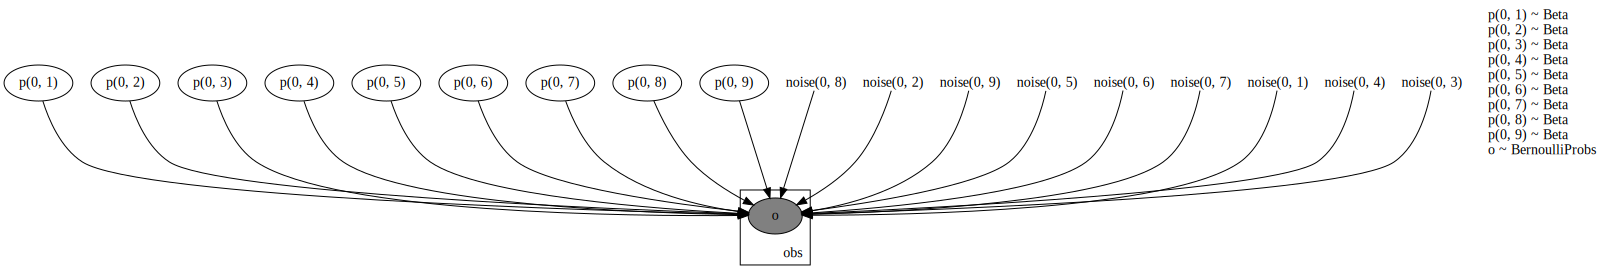

In [ ]:
numpyro.render_model(ai_model, model_args=(obs_list,), render_distributions=True, render_params=True,)

# Evaluating Prior Predictive from the Prior Distribution

Running our AI Model (without observations) to evaluate prior predictive from out prior distribution.

In our first iteration we are expecting to see around 0.5 probability for success and failure, because our prior distribution is $Beta(1,1)$ which is basically the same as $Uniform(0,1)$.

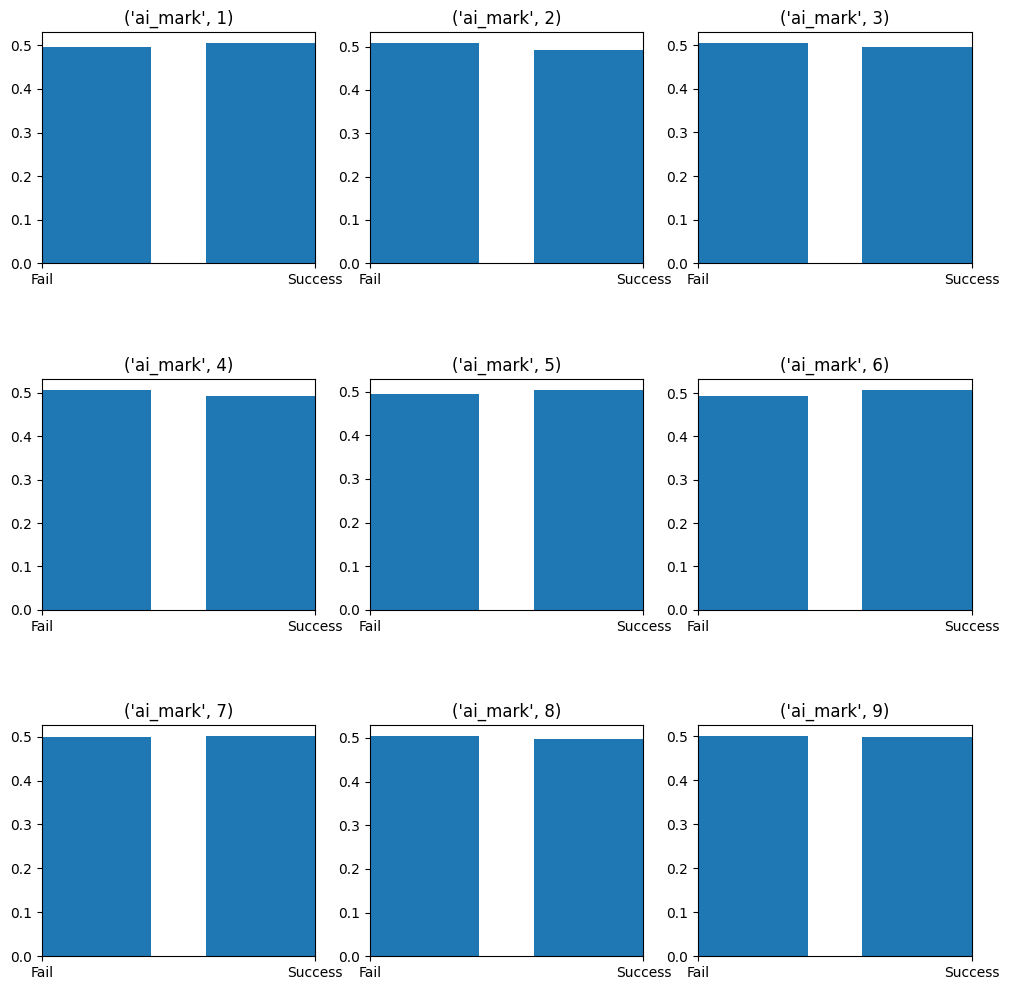

In [ ]:
prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("prior predictive")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        o_key = f"p{str((fn_num, action_param))}" # Need to revert this to o{str(key)}
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
        fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

# Running Inference using MCMC.

In [ ]:
nuts_kernel = numpyro.infer.NUTS(ai_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)
mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs_list)
mcmc.print_summary()

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.56      0.27      0.58      0.17      1.00  30612.50      1.00
   p(0, 2)      0.75      0.21      0.81      0.44      1.00  25547.95      1.00
   p(0, 3)      0.58      0.24      0.60      0.24      1.00  35496.14      1.00
   p(0, 4)      0.85      0.13      0.88      0.67      1.00  30214.82      1.00
   p(0, 5)      0.46      0.28      0.45      0.00      0.87  34205.95      1.00
   p(0, 6)      0.83      0.15      0.87      0.62      1.00  30175.64      1.00
   p(0, 7)      0.86      0.13      0.89      0.68      1.00  34742.10      1.00
   p(0, 8)      0.86      0.13      0.89      0.68      1.00  34397.00      1.00
   p(0, 9)      0.73      0.18      0.76      0.47      1.00  30562.75      1.00

Number of divergences: 0


# Posterior Predictive

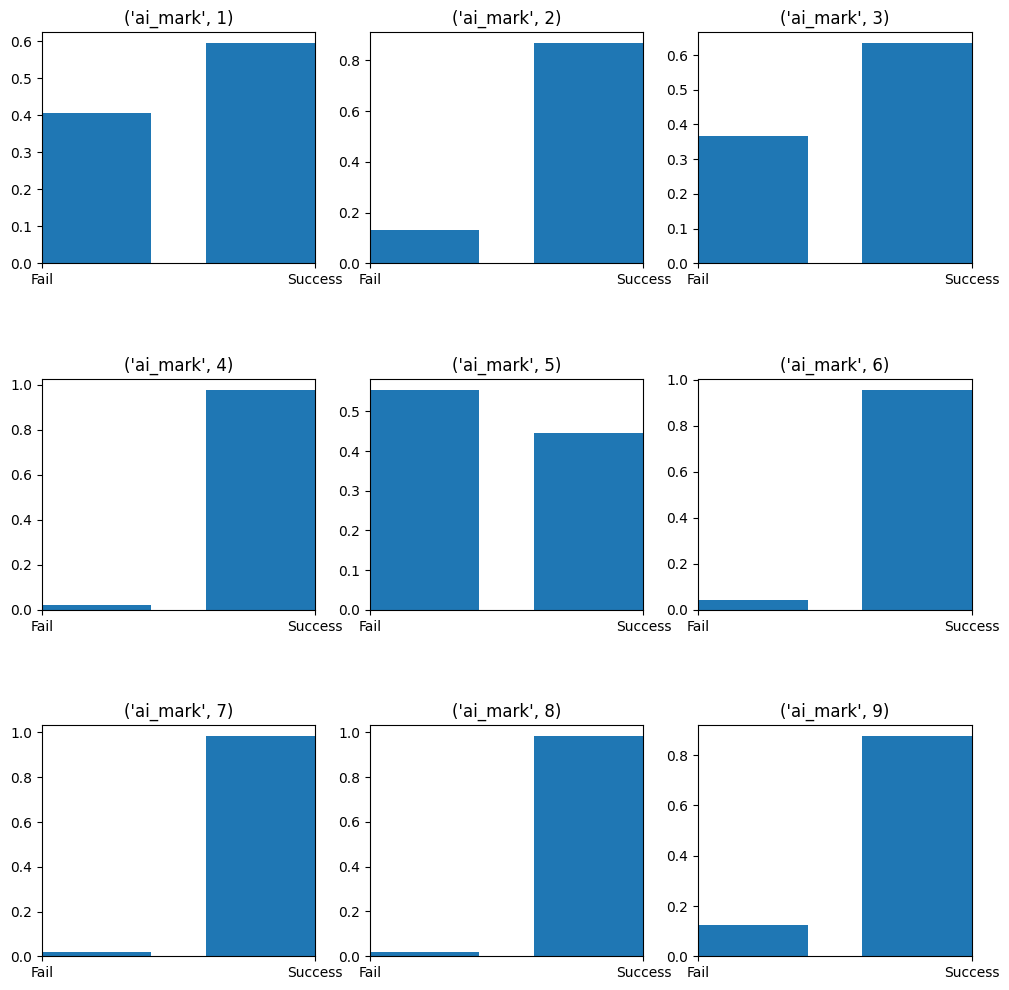

In [ ]:
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("posterior")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str((fn_num, action_param))}"
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
        fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

# Summarizing the Posterior

Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.

stat	p(0, 1)
-------------
mean	0.559
stddev	0.269
  0%	0.000
  2%	0.045
 25%	0.350
 50%	0.580
 75%	0.784
 98%	0.979
100%	1.000


stat	p(0, 2)
-------------
mean	0.753
stddev	0.209
  0%	0.002
  2%	0.227
 25%	0.641
 50%	0.810
 75%	0.919
 98%	0.993
100%	1.000


stat	p(0, 3)
-------------
mean	0.581
stddev	0.242
  0%	0.000
  2%	0.096
 25%	0.403
 50%	0.599
 75%	0.776
 98%	0.971
100%	1.000


stat	p(0, 4)
-------------
mean	0.850
stddev	0.130
  0%	0.153
  2%	0.513
 25%	0.784
 50%	0.885
 75%	0.950
 98%	0.996
100%	1.000


stat	p(0, 5)
-------------
mean	0.465
stddev	0.282
  0%	0.000
  2%	0.022
 25%	0.220
 50%	0.448
 75%	0.701
 98%	0.963
100%	1.000


stat	p(0, 6)
-------------
mean	0.826
stddev	0.151
  0%	0.006
  2%	0.436
 25%	0.750
 50%	0.867
 75%	0.943
 98%	0.995
100%	1.000


stat	p(0, 7)
-------------
mean	0.856
stddev	0.125
  0%	0.204
  2%	0.537
 25%	0.792
 50%	0.892
 75%	0.953
 98%	0.996
100%	1.000


stat	p(0, 8)
-------------
mean	0.856
stddev	0.126
  0%	0.195
  2%	0.530
 25%	0.792
 50%	0

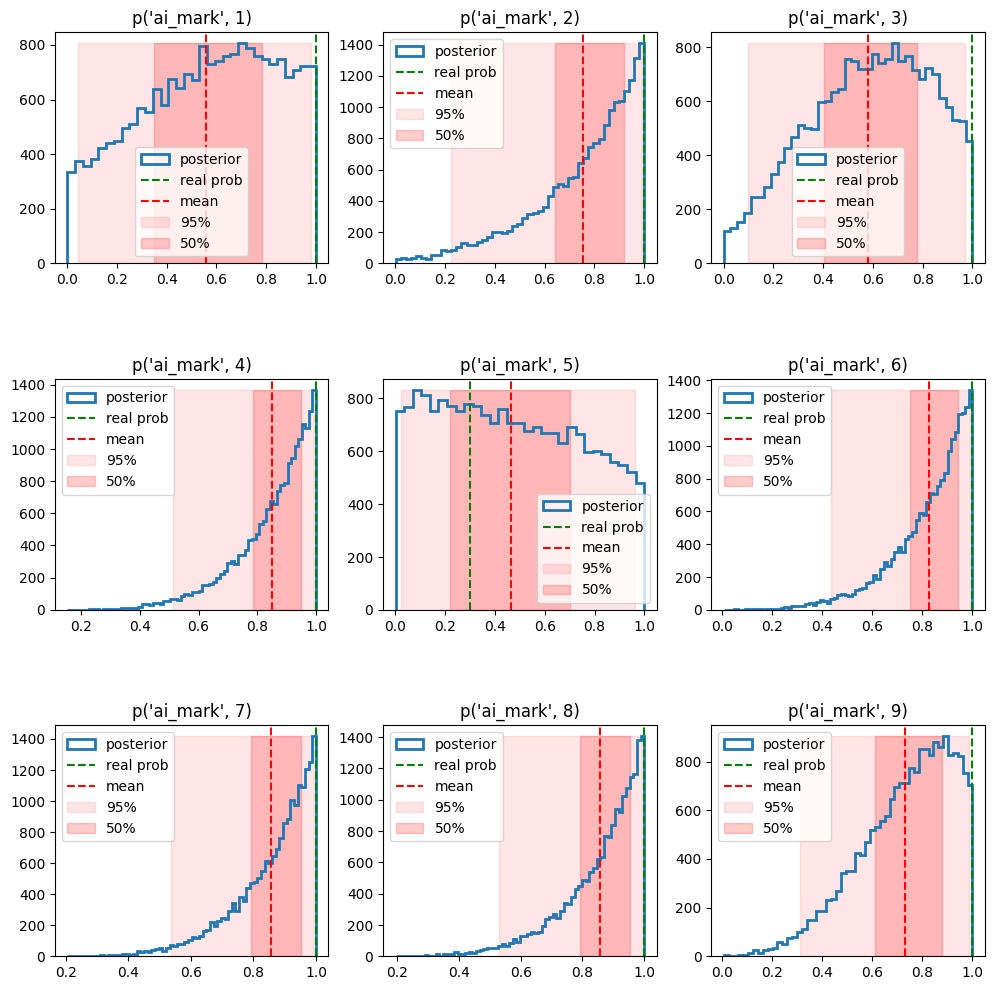

In [ ]:
distribution_stats = {}
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
# obs_list = list(obs.items())
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        key = (fn_num, action_param)
        real_param = utils.REAL_MODEL_PARAMETERS[(fn_name, action_param)]
        p_key = f"p{str(key)}"
        p = mcmc.get_samples()[p_key]
        p_mean = p.mean()
        p_stddev = p.std()
        distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
        quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
        pq = np.quantile(p, quantiles)
        print(f"stat\t{p_key}\n-------------")
        print(f"mean\t{p_mean:.3f}")
        print(f"stddev\t{p_stddev:.3f}")
        for q in range(len(quantiles)):
            print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
        print("\n")
        height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
        axs[i, j].set_title(f"p{title}")
        axs[i, j].axvline(real_param, ls="dashed", color="green", label="real prob")
        axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
        axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
        axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
        axs[i, j].legend()
plt.show()